In [1]:
import numpy as np
import experimental_methods as sim_r
import experimental_methods_freq as sim_f
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits import mplot3d
%matplotlib inline
import seaborn as sns
from matplotlib.pyplot import rc

In [2]:
rc('text', usetex=False)
rc('font', family='sans-serif')

In [49]:
mu = 0.5; sigma = 1
R = (100, -100, 0)
c = (1, 1)

In [50]:
import warnings
warnings.filterwarnings("ignore")

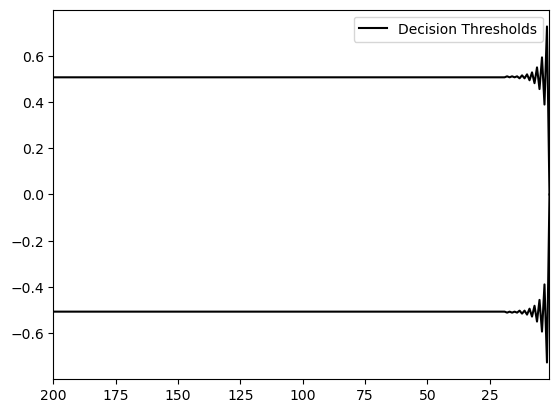

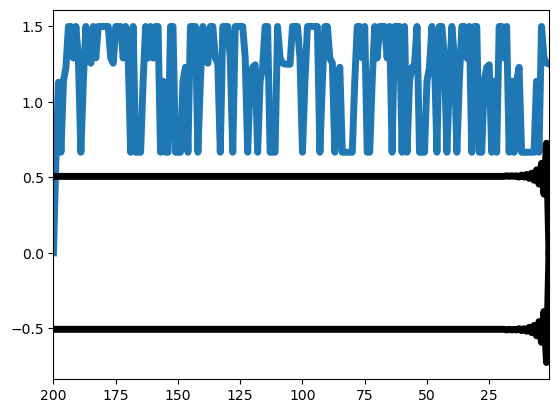

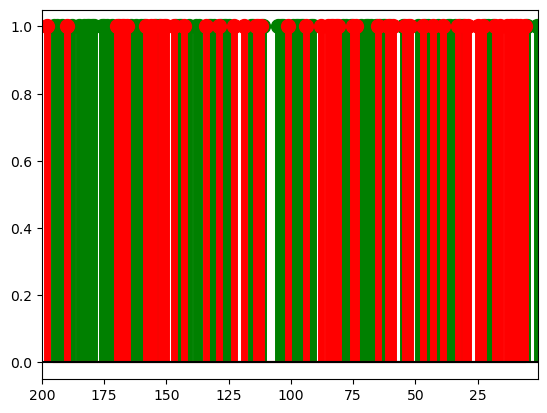

In [57]:
# Define simulation parameters:
N = 200
epsilon = 0.4; q = 0.6


# Create time step vector:
t = np.arange(N, 0, -1)

# Simulate realization of reward-maximization strategy:
block = sim_f.RewardMax(N, mu, sigma, epsilon, q, R, c)
block.experiment_sim()

# Plot reward-maximizing thresholds:
fig, ax = plt.subplots()
ax.plot(t, block.thresh, color='black', label='Decision Thresholds')
ax.plot(t, -block.thresh, color='black')
ax.set_xlim((N, 1))
ax.legend()

# Plot belief realization over thresholds:
fig, ax = plt.subplots()
ax.plot(t, block.belief, linewidth=5)
ax.plot(t, block.thresh, 'k', linewidth=5)
ax.plot(t, -block.thresh, 'k', linewidth=5)
ax.set_xlim((N, 0.8))
# ax.set_xticks(np.linspace(N, 1, 4), labels=[])
# ax.set_ylim(np.max(np.abs(ax.get_ylim()))*np.array([-1, 1]))
# ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 5), labels=[])
# print(ax.get_yticks())
# ax.spines[['top', 'right']].set_visible(False)

RT_rewarded = block.RT[block.reward == R[0]]
RT_punished = block.RT[block.reward == R[1]]
choice_rewarded = block.choice[block.reward == R[0]]
choice_punished = block.choice[block.reward == R[1]]

# Plot action timeseries representation:
fig, ax = plt.subplots()
if len(RT_rewarded) > 0:
    S = ax.stem(RT_rewarded, choice_rewarded, markerfmt='go', linefmt='green')
    S[0].set_markersize(10); S[1].set_linewidth(5)

if len(RT_punished) > 0:
    S = ax.stem(RT_punished, choice_punished, markerfmt='ro', linefmt='red')
    S[0].set_markersize(10); S[1].set_linewidth(5)
    
ax.plot(t, np.zeros_like(t), color='black')
ax.set_xlim((N, 0.8))
# ax.set_xticks(np.linspace(N, 1, 4), labels=[])
# ax.set_yticks([])
# ax.spines[['top', 'right', 'left']].set_visible(False)
choicetime = block.RT
time_lags = [choicetime[i-1] - choicetime[i] for i in range(1,len(choicetime))]
dfTL = pd.DataFrame(time_lags, columns=['TL'])
dfTL['counts'] = choicetime[0:len(choicetime)-1]
lags = dfTL.groupby(dfTL['TL']).count()

In [52]:
time_lags

[2.0,
 2.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 8.0,
 1.0,
 1.0,
 2.0,
 3.0,
 2.0,
 2.0,
 1.0,
 2.0,
 3.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 3.0,
 1.0,
 1.0,
 7.0,
 1.0,
 1.0,
 2.0,
 4.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 1.0,
 3.0,
 2.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 1.0,
 3.0,
 2.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 2.0,
 1.0,
 3.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 3.0,
 1.0,
 2.0,
 1.0,
 3.0,
 2.0,
 1.0,
 1.0,
 1.0,
 4.0,
 2.0,
 1.0,
 1.0,
 4.0,
 2.0,
 1.0,
 1.0,
 4.0,
 2.0,
 1.0,
 2.0,
 2.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 1.0,
 2.0,
 1.0,
 3.0,
 2.0,
 2.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 2.0,
 2.0]

In [6]:
def run_sim_r(N, epsilon, q):
    block = sim_r.RewardMax(N, mu, sigma, epsilon, q, R, c)
    block.experiment_sim()
    choicetime = block.RT
    time_lags = [choicetime[i-1] - choicetime[i] for i in range(1,len(choicetime))]
    dfTL = pd.DataFrame(time_lags, columns=['TL'])
    dfTL['counts'] = choicetime[0:len(choicetime)-1]
    lags = dfTL.groupby(dfTL['TL']).count()
    return np.array(time_lags), np.array(lags.index), np.array(lags.counts), dfTL.shape[0]

def run_sim_f(N, epsilon, q):
    block = sim_f.RewardMax(N, mu, sigma, epsilon, q, R, c)
    block.experiment_sim()
    choicetime = block.RT
    time_lags = [choicetime[i-1] - choicetime[i] for i in range(1,len(choicetime))]
    dfTL = pd.DataFrame(time_lags, columns=['TL'])
    dfTL['counts'] = choicetime[0:len(choicetime)-1]
    lags = dfTL.groupby(dfTL['TL']).count()
    return np.array(time_lags), np.array(lags.index), np.array(lags.counts), dfTL.shape[0]

def compute_burstiness(lags_line):
    mean = np.mean(lags_line)
    std = np.std(lags_line)
    return (std - mean)/(std+mean)

def compute_mean(lags_line):
    return np.mean(lags_line)

def compute_std(lags_line):
    return np.std(lags_line)

def bursty_sim(L):
    q = []; eps = []; b_i = []; mu_i = []; std_i = []
    for fr in np.linspace(0.5,0.99,L):
        for haz in np.linspace(0.01,0.5,L):
            print(haz,fr)
            all_lags, lags, freq, N = run_sim_f(385, haz, fr)
            q.append(fr); eps.append(haz)
            b_i.append(compute_burstiness(all_lags))
            mu_i.append(compute_mean(all_lags))
            std_i.append(compute_std(all_lags))
        
    q = np.array(q); q = q.reshape(-1,1)
    eps = np.array(eps); eps = eps.reshape(-1,1)
    b_i = np.array(b_i); b_i = b_i.reshape(-1,1)
    mu_i = np.array(mu_i); mu_i = mu_i.reshape(-1,1)
    std_i = np.array(std_i); std_i = std_i.reshape(-1,1)
    return q, eps, b_i, mu_i, std_i

def plot(q, eps, b_i):
    fig, ax = plt.subplots(figsize=(5,2.5),dpi=150)
    plt.subplots_adjust(wspace=0.4)
    plt.subplot(121)
    plt.scatter(q,b_i)
    plt.ylim([-1, 1]); plt.xlim([0.5, 1])
    plt.xlabel('$q$'); plt.ylabel('$B$')
#     q_mdl = LinearRegression(); q_mdl.fit(q,b_i)
#     plt.plot(q, q_mdl.predict(q), 'r')
    
    plt.subplot(122)
    plt.scatter(eps,b_i)
    plt.ylim([-1, 1]); plt.xlim([0, 0.5])
    plt.xlabel('$\epsilon$'); plt.yticks([])
#     eps_mdl = LinearRegression(); eps_mdl.fit(eps,b_i)
#     plt.plot(eps, eps_mdl.predict(eps), 'r')
    plt.show()
    
def convert(q,eps,b_i,m_i,s_i):
    mat = np.concatenate((q,eps,b_i,m_i,s_i), axis=1)
    return pd.DataFrame(mat, columns=['q', 'eps', 'B_i', 'mu_i', 'sig_i'])

In [7]:
q, e, b, m, s = bursty_sim(10)

0.01 0.5
0.06444444444444444 0.5
0.11888888888888888 0.5
0.17333333333333334 0.5
0.22777777777777777 0.5
0.2822222222222222 0.5
0.33666666666666667 0.5
0.3911111111111111 0.5
0.44555555555555554 0.5
0.5 0.5
0.01 0.5544444444444444
0.06444444444444444 0.5544444444444444
0.11888888888888888 0.5544444444444444
0.17333333333333334 0.5544444444444444
0.22777777777777777 0.5544444444444444
0.2822222222222222 0.5544444444444444
0.33666666666666667 0.5544444444444444
0.3911111111111111 0.5544444444444444
0.44555555555555554 0.5544444444444444
0.5 0.5544444444444444
0.01 0.6088888888888889
0.06444444444444444 0.6088888888888889
0.11888888888888888 0.6088888888888889
0.17333333333333334 0.6088888888888889
0.22777777777777777 0.6088888888888889
0.2822222222222222 0.6088888888888889
0.33666666666666667 0.6088888888888889
0.3911111111111111 0.6088888888888889
0.44555555555555554 0.6088888888888889
0.5 0.6088888888888889
0.01 0.6633333333333333
0.06444444444444444 0.6633333333333333
0.11888888888888

Text(0.5, 1.0, '$\\sigma_\\tau$')

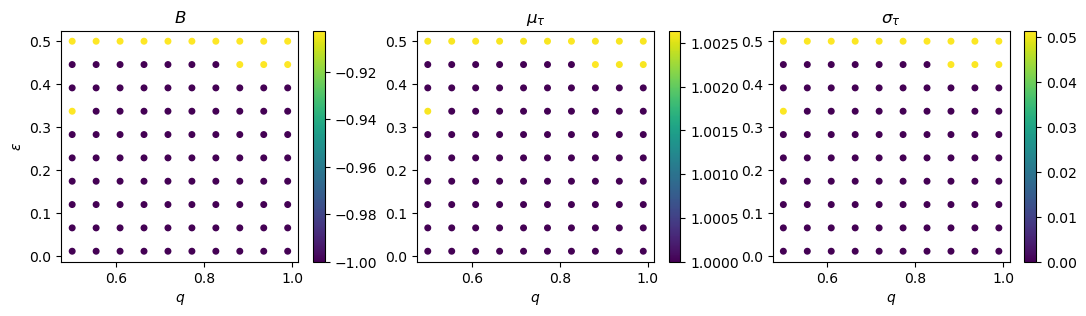

In [8]:
df = convert(q,e,b,m,s)
plt.subplots(figsize=(13,3))
plt.subplot(131)
plt.scatter(q,e, c=b, s=16)
plt.colorbar()
plt.xlabel('$q$')
plt.ylabel('$\epsilon$')
plt.title('$B$')
plt.subplot(132)
plt.scatter(q,e, c=m, s=16)
plt.colorbar()
plt.xlabel('$q$')
plt.title('$\mu_\\tau$')
plt.subplot(133)
plt.scatter(q,e, c=s, s=16)
plt.colorbar()
plt.xlabel('$q$')
plt.title('$\sigma_\\tau$')

Text(0.5, 1.0, '$\\sigma_\\tau$')

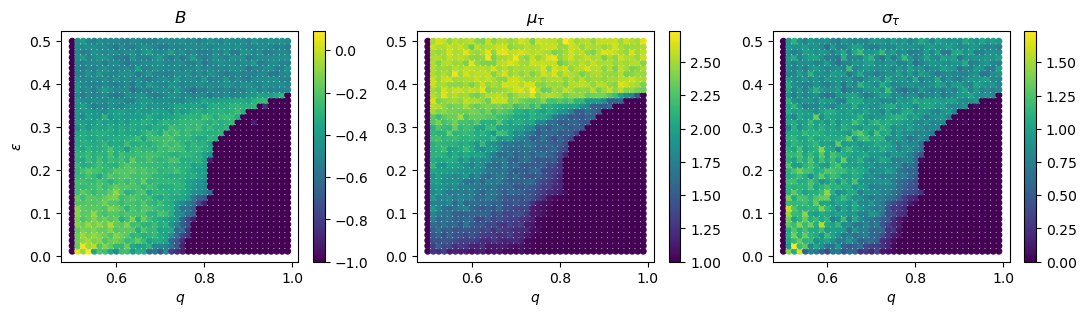

In [179]:
df = convert(q,e,b,m,s)
plt.subplots(figsize=(13,3))
plt.subplot(131)
plt.scatter(q,e, c=b, s=16)
plt.colorbar()
plt.xlabel('$q$')
plt.ylabel('$\epsilon$')
plt.title('$B$')
plt.subplot(132)
plt.scatter(q,e, c=m, s=16)
plt.colorbar()
plt.xlabel('$q$')
plt.title('$\mu_\\tau$')
plt.subplot(133)
plt.scatter(q,e, c=s, s=16)
plt.colorbar()
plt.xlabel('$q$')
plt.title('$\sigma_\\tau$')

Text(0, 0.5, '$\\epsilon$')

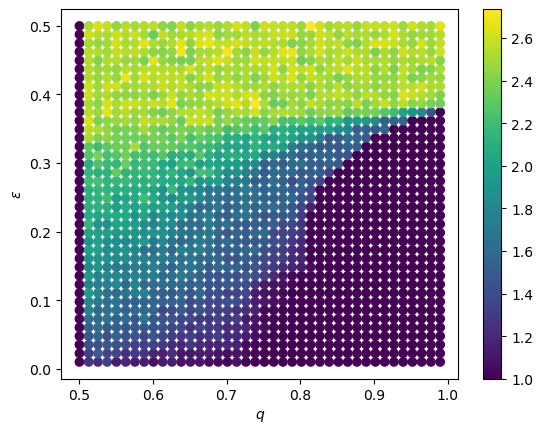

Text(0, 0.5, '$\\epsilon$')

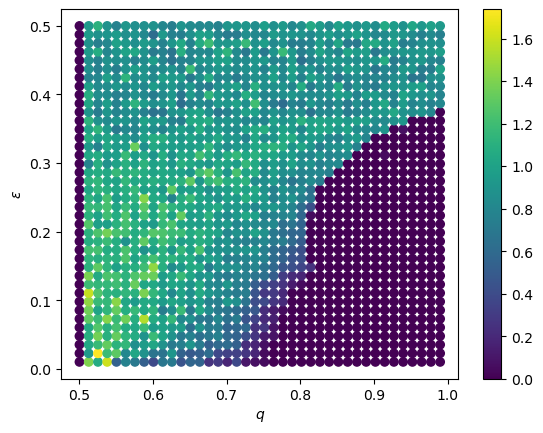

<IPython.core.display.Javascript object>


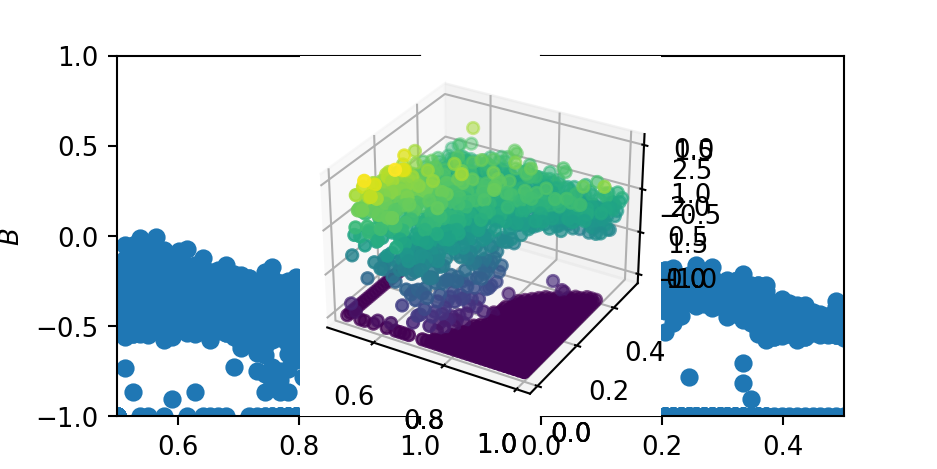

In [57]:
plot(q, e, b)

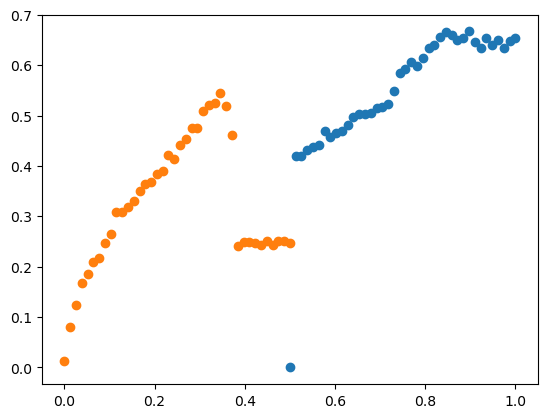

In [98]:
df = convert(q,e,b,m,s)
stdevs = [];
for x in df['q'].unique():
    stdevs.append(np.std(df[df['q'] == x]['mu_i']))
idx = np.argmax(stdevs)
ax = plt.subplots()
plt.scatter(df['q'].unique(),stdevs)


stdevs = [];
for x in df['eps'].unique():
    stdevs.append(np.std(df[df['eps'] == x]['mu_i']))
idx = np.argmax(stdevs)
plt.scatter(df['eps'].unique(),stdevs)

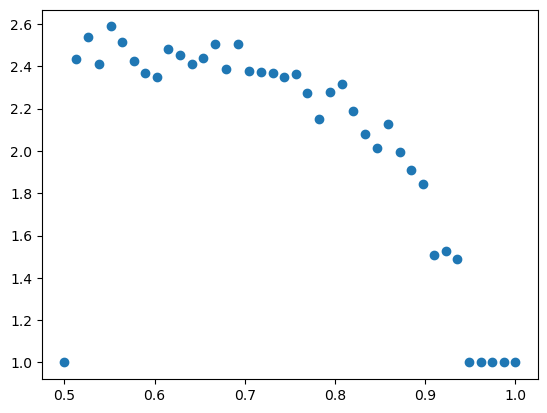

In [123]:

plt.scatter(df['q'].unique(), df[df['eps'] == df['eps'].unique()[28]]['mu_i'])

<IPython.core.display.Javascript object>


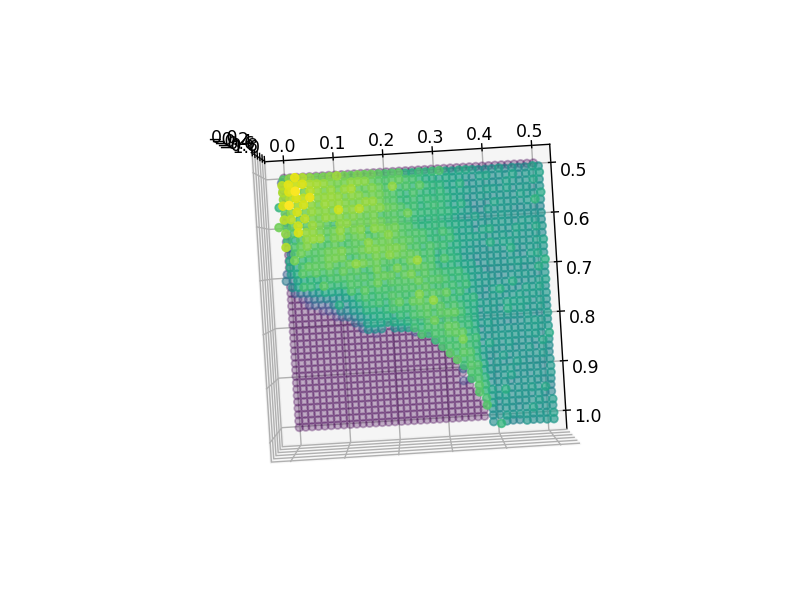

In [66]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.scatter3D(q,e,b, c=b)

In [131]:
np.random.binomial(1, 0.5)

1

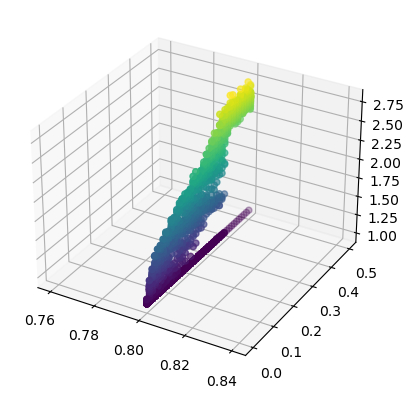

In [140]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.scatter3D(q,e,m, c=m)

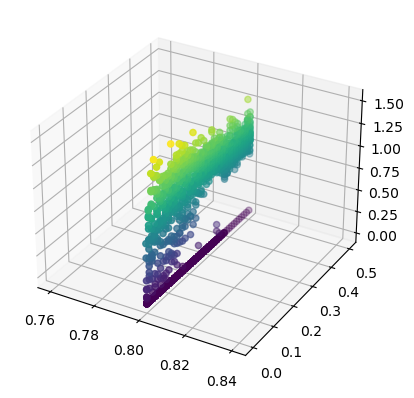

In [141]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.scatter3D(q,e,s, c=s)